# 1. initial Setup and Imports

In [ ]:
import numpy as np
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt

%matplotlib inline

# 2. Load and Split images along with applying Data Preprocessing and Data Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_path = 'gdrive/My Drive/Dataset'
valid_path = 'gdrive/My Drive/Dataset'

# ekstrak gambar ke set pelatihan dengan menerapkan prapemrosesan data dan augmentasi data
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(227,227), classes=['Clear Sky', 'Cloudy', 'Windy'], batch_size=10, subset='training')


# ekstrak gambar ke set validasi
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(227,227), classes=['Clear Sky', 'Cloudy', 'Windy'], batch_size=10, subset='validation')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 1030 images belonging to 3 classes.
Found 113 images belonging to 3 classes.


# 3. Visualization of the images after Preprocessing

In [ ]:
# plot gambar setelah menerapkan metode prapemrosesan data VGG19
def plotImages(images):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

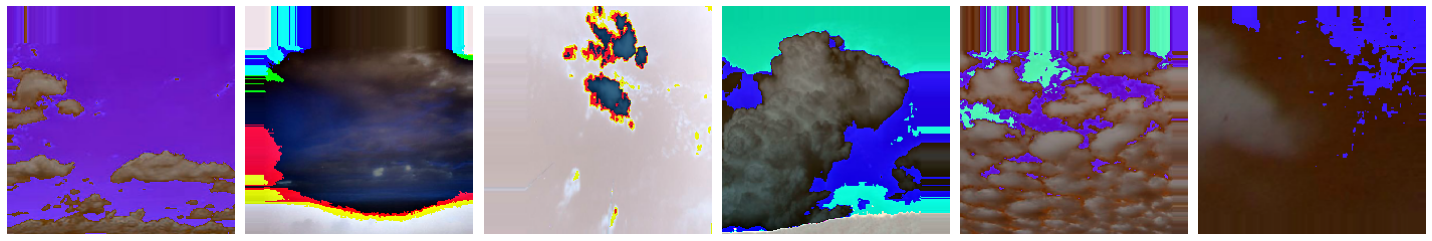

In [ ]:
imgs, labels = next(train_batches)
plotImages(imgs)

# 4. Building CNN Architecture

In [ ]:
# atur ukuran gambar input untuk model CNN yang diusulkan
IMG_SIZE = 227
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# impor basis konvolusi model VGG19 dengan bobot yang telah dilatih sebelumnya
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, 
                                        include_top=False,
                                        pooling="avg",
                                        weights='imagenet',)

In [ ]:
# ringkasan basis konvolusi model VGG19
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Inisialisasi model berurutan untuk mengelompokkan tumpukan lapisan linier
model = Sequential()

# Bekukan basis konvolusi VGG19 untuk mencegah pemutakhiran bobot yang telah dilatih sebelumnya
# selama pelatihan untuk mengekstrak fitur
base_model.trainable=False

# tambahkan basis konvolusi VGG19 untuk menginisialisasi model sekuensial
model.add(base_model)

# tambahkan lapisan NN yang terhubung erat dengan 512 unit tersembunyi
model.add(Dense(units=512, activation='relu')) 
model.add(BatchNormalization())                 
model.add(Dropout(0.3))                        

# tambahkan lapisan NN yang terhubung erat dengan 128 unit tersembunyi
model.add(Dense(units=128, activation='relu')) 
model.add(BatchNormalization())                
model.add(Dropout(0.1))                       

# tambahkan lapisan NN yang terhubung erat dengan 6 unit tersembunyi
model.add(Dense(units=3, activation='sigmoid')) 


In [ ]:
# ringkasan model CNN yang diusulkan (arsitektur)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                      

# 5. Kompilasi Model CNN yang Dibangun

In [ ]:
# kompilasi model CNN yang dibangun dengan memilih fungsi pengoptimal dan kerugian yang sesuai
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Train the CNN model

In [ ]:
# latih model
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)

Epoch 1/15
103/103 - 19s - loss: 0.5960 - accuracy: 0.7796 - val_loss: 0.7540 - val_accuracy: 0.6814 - 19s/epoch - 180ms/step
Epoch 2/15
103/103 - 17s - loss: 0.4486 - accuracy: 0.8350 - val_loss: 1.0364 - val_accuracy: 0.5398 - 17s/epoch - 169ms/step
Epoch 3/15
103/103 - 17s - loss: 0.3974 - accuracy: 0.8427 - val_loss: 0.9405 - val_accuracy: 0.6814 - 17s/epoch - 167ms/step
Epoch 4/15
103/103 - 17s - loss: 0.3369 - accuracy: 0.8641 - val_loss: 0.7754 - val_accuracy: 0.6637 - 17s/epoch - 168ms/step
Epoch 5/15
103/103 - 17s - loss: 0.3109 - accuracy: 0.8796 - val_loss: 0.3739 - val_accuracy: 0.9027 - 17s/epoch - 169ms/step
Epoch 6/15
103/103 - 18s - loss: 0.2842 - accuracy: 0.8903 - val_loss: 0.4314 - val_accuracy: 0.8407 - 18s/epoch - 171ms/step
Epoch 7/15
103/103 - 18s - loss: 0.2849 - accuracy: 0.8816 - val_loss: 1.1015 - val_accuracy: 0.6195 - 18s/epoch - 171ms/step
Epoch 8/15
103/103 - 17s - loss: 0.2589 - accuracy: 0.9019 - val_loss: 0.9069 - val_accuracy: 0.6195 - 17s/epoch - 169

In [ ]:
# store the losses of training
loss = model_details.history['loss']
validation_loss = model_details.history['val_loss']

In [ ]:
# store the accuracy of training
accuracy = model_details.history['accuracy']
validation_accuracy = model_details.history['val_accuracy']

# 7. Fine Tune the CNN model

In [ ]:
# mencairkan basis konvolusi VGG19 untuk menyempurnakan yang mengadaptasi bobot yang telah dilatih sebelumnya ini
# untuk bekerja dengan kumpulan data baru
base_model.trainable=True

In [ ]:
# ringkasan model CNN fine-tune
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                      

In [ ]:
# melatih dan menyempurnakan model dengan jumlah zaman yang sesuai
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=9, verbose=2)

Epoch 1/9
103/103 - 18s - loss: 0.2141 - accuracy: 0.9155 - val_loss: 0.5626 - val_accuracy: 0.7788 - 18s/epoch - 170ms/step
Epoch 2/9
103/103 - 17s - loss: 0.1805 - accuracy: 0.9272 - val_loss: 0.5469 - val_accuracy: 0.7876 - 17s/epoch - 169ms/step
Epoch 3/9
103/103 - 17s - loss: 0.2107 - accuracy: 0.9291 - val_loss: 0.6533 - val_accuracy: 0.7611 - 17s/epoch - 169ms/step
Epoch 4/9
103/103 - 17s - loss: 0.2127 - accuracy: 0.9155 - val_loss: 0.5869 - val_accuracy: 0.8230 - 17s/epoch - 167ms/step
Epoch 5/9
103/103 - 19s - loss: 0.1785 - accuracy: 0.9369 - val_loss: 0.6265 - val_accuracy: 0.7788 - 19s/epoch - 182ms/step
Epoch 6/9
103/103 - 17s - loss: 0.1976 - accuracy: 0.9165 - val_loss: 0.5994 - val_accuracy: 0.8053 - 17s/epoch - 169ms/step
Epoch 7/9
103/103 - 17s - loss: 0.2083 - accuracy: 0.9252 - val_loss: 0.6081 - val_accuracy: 0.7522 - 17s/epoch - 170ms/step
Epoch 8/9
103/103 - 17s - loss: 0.1615 - accuracy: 0.9359 - val_loss: 0.5320 - val_accuracy: 0.7965 - 17s/epoch - 167ms/step


# 8. Visulization of Accuracy and Loss in Training and  Validation sets

In [ ]:
# tambahkan kerugian ke kerugian yang disimpan sebelumnya
loss.extend(model_details.history['loss'])
validation_loss.extend(model_details.history['val_loss'])

In [ ]:
# tambahkan akurasi ke akurasi tersimpan sebelumnya
accuracy.extend(model_details.history['accuracy'])
validation_accuracy.extend(model_details.history['val_accuracy'])

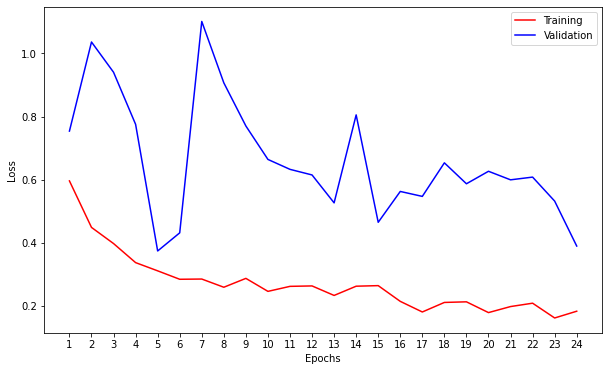

In [ ]:
# merencanakan kerugian pelatihan dan validasi
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

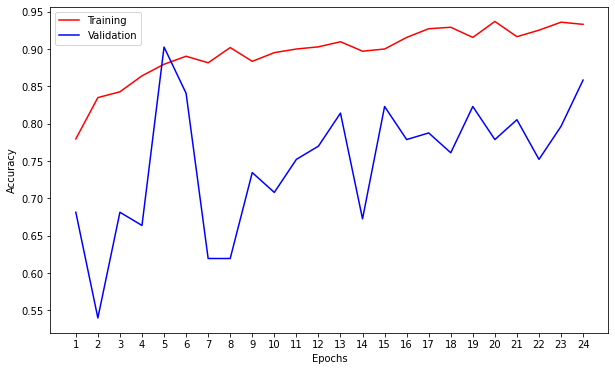

In [ ]:
# merencanakan akurasi pelatihan dan validasi
epochs = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs,accuracy,c="red",label="Training")
plt.plot(epochs,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()

In [ ]:
# Evaluating the model on test data
filenames = valid_batches.filenames
nb_samples = len(filenames)

scores =model.evaluate_generator(valid_batches, nb_samples)
print("Accuracy: %.2f%%" % (scores[1]*100))

<ipython-input-73-6e08a77dd317>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores =model.evaluate_generator(valid_batches, nb_samples)


Accuracy: 85.84%
